In [1]:
%matplotlib inline

# Python 速習 (その2)

### 経済動学 講義資料



神戸大学 佐藤健治

2015-4-17

このノートではPythonを使って

離散時間力学系を可視化する方法を学ぶ

入門的な段階で大きな問題になることは少ないけれども大切なこと: 

1. 解析学 &mdash; **無限**や**極限**の概念が中心
1. コンピュータ &mdash; **有限**しか扱えない


**有限** の意味するところは

1. $0$と$1$の有限個の連なりで表現できる対象に対する
1. 有限回の計算

のみが可能ということ

離散時間力学系は写像 $F: X \to X$ のことだったので、この有限制約の中で、

1. $X$
1. $F$
1. 軌道の収束・発散

をどのように表現するか？

# $X$ をどのように表現するか？

 $X = \mathbb{R}^n$ &mdash; 有限次元ベクトル空間

 $X \ni x = [x_1 \ \dots x_n]$ 

 各$x_i$ は**実数**
 

 実数は有限の概念ではない
 
 $\sqrt{2} = 1.41421356\dots $

 
 **実は、$0.1$ など「普通の」小数でさえ有限の概念ではないので近似はまぬがれない**

# そもそも数はどのように表現されるか？

## 整数


$2 = \color{red}{1} \times 2^1 + \color{red}{0} \times 2^0 = (10)$

$3 = \color{red}{1} \times 2^1 + \color{red}{1} \times 2^0 = (11)$

$10 = \color{red}{1}\times 2^3 + \color{red}{0} \times 2^2 + \color{red}{1} \times 2^1 + \color{red}{0} \times 2^0 = (1010)$


もっと大きな数字の場合も

$N = a_n \times 2^n + a_{n-1} \times 2^{n-1} + \dots + a_0 \times 2^0$

In [2]:
format(201119302093024920940294035, 'b')

'1010011001011100101010110011011010000000101100110010100110010101001111111010111110010011'

原理的に有限の01の列で表現できるので

整数が問題になることはまずない

## 小数 


$0.5 = \color{red}{1} \times 2^{-1} = (0.1)$

$0.75 = \color{red}{1} \times 2^{-1} + \color{red}{1} \times 2^{-2} = (0.11)$

つまり小数点以下は

\begin{align*}
& a_{1} \times 2^{-1} + \dots + a_{n} \times 2^{-n} \\
&= [a_{1} \times 2^{n-1} + \dots a_{n} \times 2^0] \div 2^n \\
&= \text{Integer} / 2 ^n
\end{align*}

と表されている (10進小数は, $\text{Integer}/10^n$ と書ける数である)


## 疑問

 $\text{Integer} / 2 ^n$ で一般の小数、例えば $0.1$ を表現できる？

In [3]:
0.1 == 3602879701896397 / 2 ** 55

True

In [4]:
'0.' + '0' * (55 - 53) + format(3602879701896397, 'b')

'0.001100110011001100110011001100110011001100110011001101'

これが `0.1` の2進数表現

これは正確な表現か？

## 簡単な実験

In [5]:
1.0 == 0.25 + 0.25 + 0.25 + 0.25

True

OK

In [6]:
1.0 == sum(0.1 for _ in range(10)) # 0.1 を10回足す

False

何かがおかしい？

## 確認

任意の精度まで正確に10進表現してくれる`Decimal`を使って確認してみる

In [7]:
import decimal
n = decimal.Decimal('0.1')

In [8]:
decimal.Decimal('3602879701896397') / 2 ** 55 - decimal.Decimal('0.1')

Decimal('5.5511151231E-18')

In [9]:
decimal.Decimal('115292150460684697') / 2 ** 60 - decimal.Decimal('0.1')

Decimal('-5.2041704279E-19')

`0.1` は2進数表現では有限長の小数にならない → 近似精度をいくらでも増やせる

`0.1 == 3602879701896397 / 2 ** 55` が `True` と評価される理由は **左辺は長い小数を見栄え良くするために丸めて表示されているが実は右辺の内部表現を持っている** から 

実用上多くの場合には問題にならない。ただし、問題が起こることもあるので、数表現自体に誤差があることに注意が必要です。いずれにせよこのように表現される「(倍精度)浮動小数点数」が実数や有理数の表現として使われます。

## 数の表現

よく使う3つの数表現を挙げておきましょう。

整数 (`int`型)

In [10]:
t = 10
type(t)

int

浮動小数点数 (float型)

In [11]:
x = - 0.3
type(x)

float

複素数 (complex型)

In [12]:
c = 1.0 - 2.0j
type(c)

complex

# ベクトルの表現

数の表現が確定したところで、ベクトルを表現する方法に入りましょう。外部ライブラリを使わずに表現しようとすると、**リスト** と呼ばれるものを使うことができます。ただし、足し算やスカラー倍などの基本演算でさえ定義されていないので、ベクトルの表現としては実用的ではありません。

In [13]:
v = [1.0 , 2.0 ,3]
v

[1.0, 2.0, 3]

In [14]:
w = [2, 3, 4]
w

[2, 3, 4]

In [15]:
v + w

[1.0, 2.0, 3, 2, 3, 4]

In [16]:
v * 3

[1.0, 2.0, 3, 1.0, 2.0, 3, 1.0, 2.0, 3]

# Numpy 

数ベクトルの表現には、通常 `Numpy` の `ndarray` という型を使います。便利かつ高速だからです。これを$X$の表現とします。

使う前にインポートします。

In [17]:
import numpy as np

## ベクトルの定義

$x = [1.0, 2.1, 3.0]$

$y = [-1.0, 1.0, 8.9]$

In [18]:
x = np.array([1.0, 2.1, 3.0])
y = np.array([-1.0, 1.0, 8.9])

## ベクトルの和

$x + y$

In [19]:
x + y

array([  0. ,   3.1,  11.9])

## 線形結合

$3x - 2y$

In [20]:
3 * x - 2 * y

array([ 5. ,  4.3, -8.8])

# $F$ をどのように表現するか?

ベクトルの表現が定まったところで、次に写像を作ります。

Pythonの関数が基本です。

In [21]:
def f(a):
    # do something
    return 2 * a

In [22]:
f(x)

array([ 2. ,  4.2,  6. ])

## 線形写像

線形写像は行列積で表現されます。

In [23]:
A = np.array([
        [1.2, -0.8, 0],
        [0.1, 0.2,  0], 
        [0,   0,    1.2]
    ])

np.dot(A, x) # 行列 × ベクトル

array([-0.48,  0.52,  3.6 ])

したがって、線形力学系

$x_t \mapsto Ax_t$

を表現する基本のコードは次の関数のようになります

In [24]:
def fa(x):
    return np.dot(A, x)

# 写像の族の表現

われわれはこれから「力学系というもの」「線形力学系というもの」に対して実行可能な可視化のコードを書こうとしているわけです。

上記では写像 $A$ を決め打ちしてしまいましたが、「力学系というもの」という一段抽象度の高い概念をコードにしてしまう方がコードをクリーンに保てることがよくあります。

我々がいま採用している力学系の定義に絶対に必要なものは、「前向きに進めるための写像」と「$X$の次元」だけですから、これを備えているものを力学系であると、Pythonコードで表現しておきましょう。

## クラス

クラスという仕組みを使います。これは「考察の対象」とその対象がもつ「動作」を組み合わせて表現するための方法です。

In [25]:
class System:
    """Dynamical System"""
    def __init__(self, dim):
        self.dim = dim

    def forward(self, x):
        pass

## 線形写像のクラス

線形写像のクラスを作ります。上で定義した `System`クラスの `dim` と `forward` を引き継ぎ、線形システム特有の事情にあわせて調整します。メソッド(動作を表す関数のこと)も具体的に定義しておきます。

In [26]:
class LinearSystem0(System):

    def __init__(self, A):
        self.A = A
        super().__init__(A.shape[0])

    def forward(self, x):
        return np.dot(self.A, x)

## インスタンス化

「システムというもの」から特定のシステムを作ることを**インスタンス化**といいます。

次のコードがインスタンス化のためのコードです。オブジェクトが生成され、その直後に `__init__()` メソッドが呼び出されます。その際に仮引数 `A` は `M` で置き換えられます。

In [27]:
theta = np.pi / 7.0
M = 0.9 * np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

In [28]:
rot = LinearSystem0(M)

## 使ってみる

In [29]:
x0 = np.array([1.0, 0.5])
x1 = rot.forward(x0)
x1

array([ 0.6156243 ,  0.79593136])

In [30]:
x2 = rot.forward(x1)
x2

array([ 0.18838499,  0.88579687])

# シミュレーション

`for`を使って繰り返し写像を適用します。これがシミュレーションの基本コードです

In [31]:
T = 5
x0 = np.array([1.0, 0.5])
for i in range(T):
    x = x0
    print(x)
    x0 = rot.forward(x)

[ 1.   0.5]
[ 0.6156243   0.79593136]
[ 0.18838499  0.88579687]
[-0.19314346  0.79183133]
[-0.46582109  0.56665221]


## 汎用的なシミュレーションコード

次のようにシミュレーションのコードを書きます。引数として、`system`を取りますが、`LinearSystem0`のインスタンスでなくとも `forward`メソッドさえ実装されていれば動きます。

In [32]:
def run0(system, x0, time):

    path = np.empty((time, len(x0)))

    path_iter = iter(path)
    tick = system.forward

    prev_state = next(path_iter)
    prev_state[:] = x0
    for state in path_iter:
        state[:] = tick(prev_state)
        prev_state = state
    return path

In [33]:
path = run0(rot, x0, 100)
path[-10:]

array([[  3.19365135e-05,  -3.88494564e-05],
       [  4.10669567e-05,  -1.90308752e-05],
       [  4.07315131e-05,   6.04852781e-07],
       [  3.27918505e-05,   1.63959252e-05],
       [  2.01874599e-05,   2.61000620e-05],
       [  6.17749240e-06,   2.90469185e-05],
       [ -6.33353156e-06,   2.59656145e-05],
       [ -1.52751354e-05,   1.85815746e-05],
       [ -1.96421981e-05,   9.10240860e-06],
       [ -1.94817564e-05,  -2.89299210e-07]])

数字だけを見ていても力学系の動作が掴みづらいので可視化してみましょう

# 可視化

matplotlib というライブラリを使います。使う前にインポートする必要があります。

In [34]:
import matplotlib.pyplot as plt

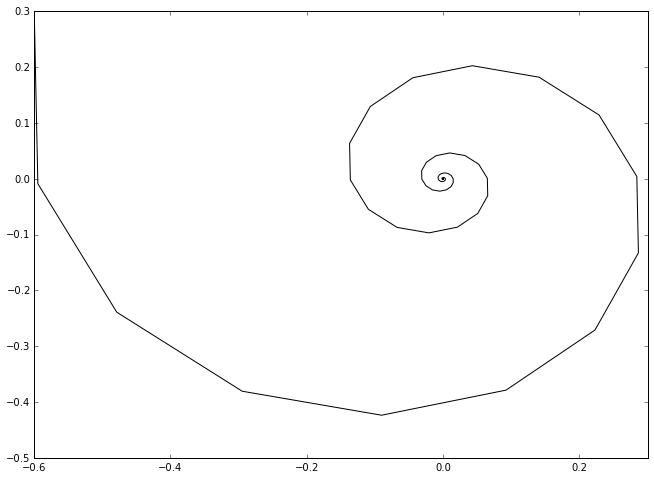

In [35]:
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
ax.plot(path[:,0], path[:,1], color='black')
plt.show()

動きを表現するために矢線をつけてみます

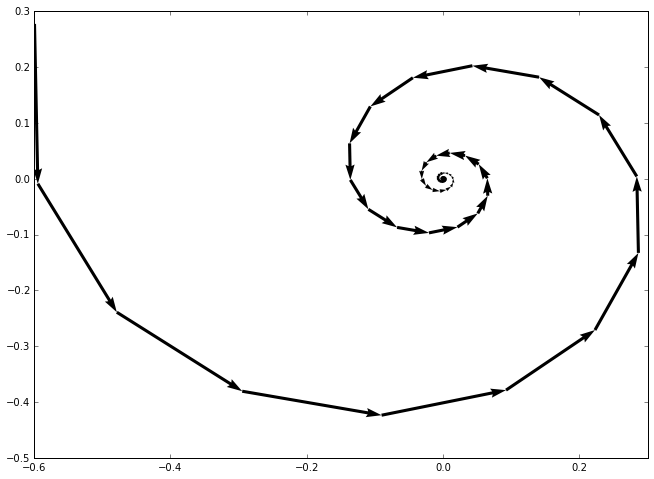

In [36]:
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
ax.quiver(path[:-1, 0], path[:-1, 1], path[1:, 0]-path[:-1, 0], 
          path[1:, 1]-path[:-1, 1],
          scale_units='xy', angles='xy', scale=1, width=0.005)
plt.show()

先ほどの軌道はゼロに収束しているように見えますが、

- シミュレーションが有限時間しか実行できないことと
- 浮動小数点数には必ず誤差がある

という理由から、シミュレーションでは収束性を確実には判定できません。しかし、力学系の振る舞いの特徴をつかむ上では役に立つでしょう。収束性の判定条件 

$\| x_t - x^* \| < \epsilon$ 

が部分的にでも成り立っているかを見るために、ノルムを計算してこれをプロットしてみましょう。

In [37]:
epsilon = 1e-2
norms = np.sqrt(np.sum(path ** 2, axis=1))

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
ax.plot(norms[-80:], color='black', linewidth=2)
ax.hlines(epsilon, *ax.get_xlim(), color='red', linestyle='dotted', linewidth=2)

# 非線形システムの例

## Tinkerbell Map

In [38]:
class Tinkerbell(System):
    """
    Tinkerbell map [http://en.wikipedia.org/wiki/Tinkerbell_map]
    """
    def __init__(self, a=0.9, b=-0.6013, c=2.0, d=0.5):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        super().__init__(dim=2)

    def forward(self, x):
        return np.array([
            x[0] * x[0] - x[1] * x[1] + self.a * x[0] + self.b * x[1],
            2 * x[0] * x[1] + self.c * x[0] + self.d * x[1]
        ])


## Henon Map

In [39]:
class Henon(System):
    """
    Henon map [http://en.wikipedia.org/wiki/Hénon_map]
    """
    def __init__(self, a=1.4, b=0.3):
        self.a = a
        self.b = b
        super().__init__(2)

    def forward(self, x):
        return np.array([
            1 - self.a * x[0] * x[0] + x[1],
            self.b * x[0]
        ])

シミュレーションのコードが繰り返しでてくるので、これもクラスにしておきましょう

In [40]:
class Simulation:
    def __init__(self, system, x0, duration):
        self.system = system
        self.x0 = x0
        self.duration = duration
    
    def run(self, x0=None, duration=None):
        system = self.system
        x0 = self.x0[:] if x0 is None else x0
        duration = self.duration if duration is None else duration
        
        path = np.empty((duration, len(x0)))
        path_iter = iter(path)
        tick = system.forward

        prev_state = next(path_iter)
        prev_state[:] = x0
        for state in path_iter:
            state[:] = tick(prev_state)
            prev_state = state
        return path
    
    def plot(self, fig_options={}, plot_options={}):
        path = self.run()
        
        fig = plt.figure(**fig_options)
        ax = fig.add_subplot(111)
        ax.plot(path[:,0], path[:,1], **plot_options)
        plt.show()
    
    def __iter__(self):
        self.counter = 0
        self.x = self.x0
        return self
        
    def __next__(self):
        while self.counter < self.duration:
            self.counter += 1
            x = self.x[:]
            self.x = self.system.forward(x)
            return x
        raise StopIteration
    

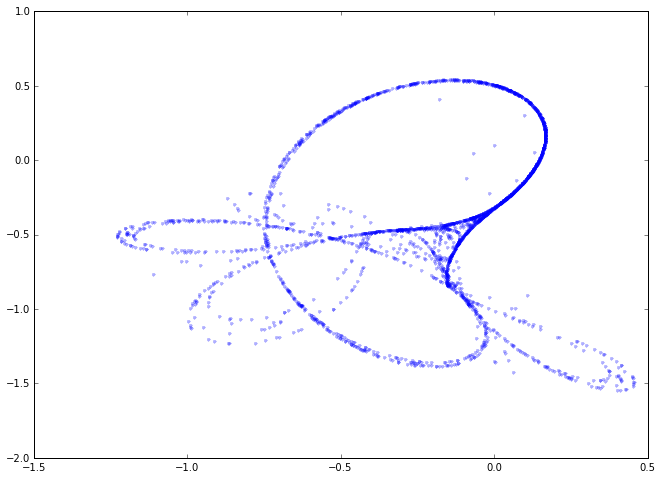

In [41]:
tkb = Tinkerbell()
sim_tkb = Simulation(tkb,  [0.0, 0.1], duration=3000)
sim_tkb.plot(fig_options=dict(figsize=(11,8)),
            plot_options=dict(linestyle='', marker='.', alpha=0.3))

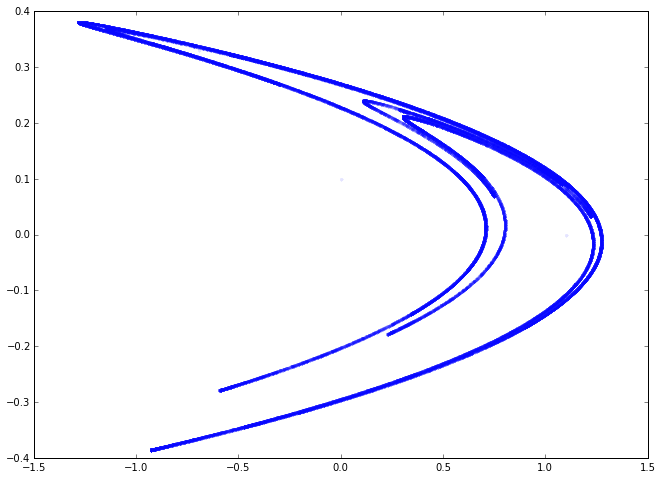

In [42]:
henon = Henon()
sim_henon = Simulation(henon,  [0.0, 0.1], duration=60000)
sim_henon.plot(fig_options=dict(figsize=(11,8)),
               plot_options=dict(linestyle='', marker='.', alpha=0.1))

`__iter__` と `__next__` というメソッドを定義したことで `for` でループを回すことができるようになります [イテレータクラス](https://docs.python.org/3.3/tutorial/classes.html#iterators)

In [43]:
print("({:>22}, {:>22})".format("x", "y"))
print("-" * 50)
for x,y in Simulation(tkb,  [0.0, 0.1], duration=10):
    print("({:>22}, {:>22})".format(x, y))

(                     x,                      y)
--------------------------------------------------
(                   0.0,                    0.1)
(              -0.07013,                   0.05)
(  -0.09076378310000001,   -0.12227299999999999)
( -0.014877272096376182,    -0.2204681460980274)
(   0.07079308114313376,   -0.13342868804559813)
(   0.13115288869480732,   0.055980162384200643)
(   0.09844402981613778,     0.3049797785942996)
(  -0.17810615237921568,      0.409424825763938)
(   -0.5423895713096526,    -0.2973420526871539)
(  -0.10358468712864322,    -0.9108997119842471)


# 関数型プログラミング

システムを表現するクラスとそのサブクラス, シミュレーションを表すクラスを作りました。オブジェクト指向と言われるパラダイムを使っています

Pythonは関数型プログラミングというプログラミング手法も利用できます。関数を引数に取る関数を書くことができるので、クラスを作ることは必ずしも必要ではありません。

In [44]:
def linearsys(mat):
    def f(x):
        return np.dot(mat, x)
    return f

def quiver_plot(func, x0, duration, axis=None, quiver_options={}):
    if axis is None:
        fig = plt.figure(figsize=(11,8))
        ax = fig.add_subplot(111)
    else:
        ax = axis
    
    path = np.empty((duration, len(x0)))
    path[0, :] = x0[:]
    for i in range(1, duration):
        path[i, :] = func(path[i-1, :])
        
    ax.quiver(path[:-1, 0], path[:-1, 1], path[1:, 0]-path[:-1, 0], 
              path[1:, 1]-path[:-1, 1],
              scale_units='xy', angles='xy', scale=1, width=0.005,
              **quiver_options)
    
    return path

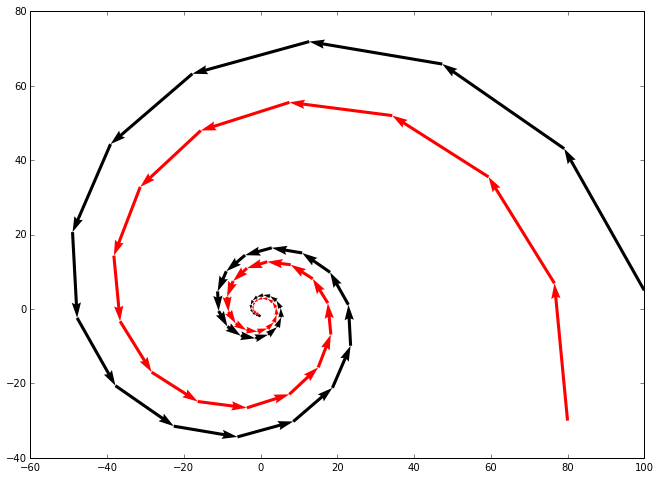

In [45]:
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)

f = linearsys(M)
x0, x1 = np.array([100, 5]), np.array([80, -30])

quiver_plot(f, x0, duration=40, axis=ax)
quiver_plot(f, x1, duration=40, axis=ax, quiver_options=dict(color='red'))

plt.show()

# 線形写像の固有値, 固有ベクトル


線形写像の固有値・固有ベクトルと力学系の挙動との関係を可視化してみましょう。固有値計算のために、必要なライブラリをインポートします。

In [46]:
import numpy.linalg as la

\begin{align}
    A = \begin{bmatrix}
            1 & 3 \\
            2 & 4 
        \end{bmatrix}
\end{align}

In [47]:
A = np.array([
        [0.4, 1.0],
        [0.01, 1.2]
    ])

## 固有値と固有ベクトルの計算

In [48]:
s, v = la.eig(A)

In [49]:
print(s)

[ 0.38768944  1.21231056]


In [50]:
print(v)

[[-0.99992423 -0.77618596]
 [ 0.01230963 -0.63050405]]


## 固有値・固有ベクトルであることの確認

\begin{align}
Av_i = s_i v_i
\end{align}

In [51]:
np.allclose(np.dot(A, v[:, 0]), np.dot(s[0], v[:, 0]))

True

In [52]:
np.allclose(np.dot(A, v[:, 0]), np.dot(s[0], v[:, 0]))

True

## 可視化

固有空間の可視化

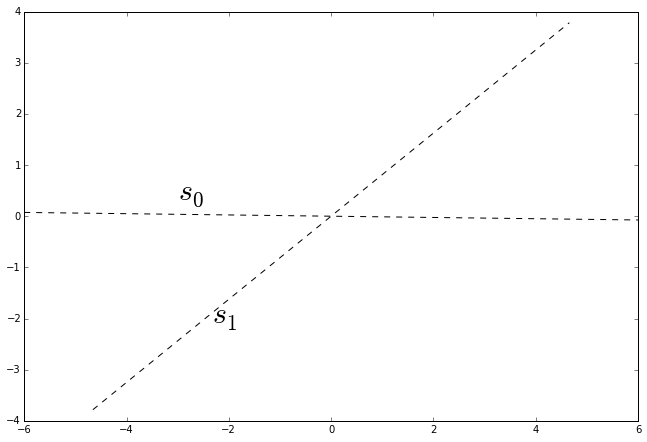

In [53]:
v0_line = 6 *  np.array([v[:, 0], -v[:, 0]])
v1_line = 6 * np.array([v[:, 1], -v[:, 1]])

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(v0_line[:, 0], v0_line[:, 1], color='black', linestyle='dashed')
ax.plot(v1_line[:, 0], v1_line[:, 1], color='black', linestyle='dashed')

ax.text(3 * v[0,0], 3 * v[1,0] + 0.3, '$s_0$', fontsize=30)
ax.text(3 * v[0,1], 3 * v[1,1] - 0.2, '$s_1$', fontsize=30)

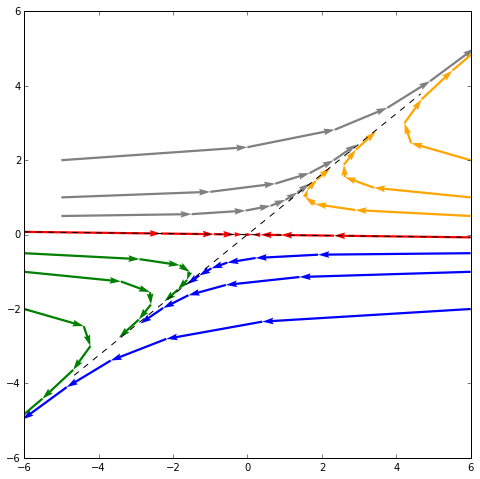

In [54]:
v0_line = 6 *  np.array([v[:, 0], -v[:, 0]])
v1_line = 6 * np.array([v[:, 1], -v[:, 1]])

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(v0_line[:, 0], v0_line[:, 1], color='black', linestyle='dashed')
ax.plot(v1_line[:, 0], v1_line[:, 1], color='black', linestyle='dashed')

xlim = ax.get_xlim()


f = linearsys(A)
# Upper Left
quiver_plot(f, np.array([- 5.0, 0.5]), duration=7, 
            axis=ax, quiver_options=dict(color='gray'))
quiver_plot(f, np.array([- 5.0, 1.0]), duration=6, 
            axis=ax, quiver_options=dict(color='gray'))
quiver_plot(f, np.array([- 5.0, 2.0]), duration=6, 
            axis=ax, quiver_options=dict(color='gray'))

# Upper Right
quiver_plot(f, np.array([6.0, 0.5]), duration=7, 
            axis=ax, quiver_options=dict(color='orange'))
quiver_plot(f, np.array([6.0, 1.0]), duration=6, 
            axis=ax, quiver_options=dict(color='orange'))
quiver_plot(f, np.array([6.0, 2.0]), duration=6, 
            axis=ax, quiver_options=dict(color='orange'))

# Lower Right
quiver_plot(f, np.array([6.0, -0.5]), duration=7, 
            axis=ax, quiver_options=dict(color='blue'))
quiver_plot(f, np.array([6.0, -1.0]), duration=6, 
            axis=ax, quiver_options=dict(color='blue'))
quiver_plot(f, np.array([6.0, -2.0]), duration=6, 
            axis=ax, quiver_options=dict(color='blue'))

# Lower Left
quiver_plot(f, np.array([-6.0, -0.5]), duration=7, 
            axis=ax, quiver_options=dict(color='green'))
quiver_plot(f, np.array([-6.0, -1.0]), duration=6, 
            axis=ax, quiver_options=dict(color='green'))
quiver_plot(f, np.array([-6.0, -2.0]), duration=6, 
            axis=ax, quiver_options=dict(color='green'))

# Stable Manifold

quiver_plot(f, v0_line[0], duration=10, 
            axis=ax, quiver_options=dict(color='red'))
quiver_plot(f, v0_line[1], duration=10, 
            axis=ax, quiver_options=dict(color='red'))

ax.set_xlim(xlim)
ax.set_ylim(xlim)
plt.show()